In [1]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import pandas as pd
from collections import *
import seaborn as sns
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split, KFold
from sklearn.preprocessing import MultiLabelBinarizer, MinMaxScaler
from sklearn.metrics import fbeta_score, precision_score, make_scorer, average_precision_score
import warnings
from scipy.misc import imrotate
import skimage.io as sio
from scipy.io import loadmat
import math
from pdb import set_trace as t
from glob import glob
from skimage import feature
from scipy import ndimage

In [2]:
# Check for SIFT and SURF. If this fails, SIFT/SURF will not run
sift = cv2.xfeatures2d.SIFT_create()
print type(sift)
print 'CV2 Loaded, Version: ' + cv2.__version__

<type 'cv2.xfeatures2d_SIFT'>
CV2 Loaded, Version: 3.2.0-dev


In [3]:
df = pd.read_csv('../data/train.csv')
image_paths = sorted(glob('../data/train-jpg/*.jpg'))
image_names = list(map(lambda row: row.split("/")[-1][:-4], image_paths))

In [4]:
def run_sift(directory, filename):
    gray_img = cv2.imread(directory + filename, 0)
    color_img = cv2.imread(directory + filename)
    gray_img = cv2.resize(gray_img, (0, 0), fx=0.5, fy=0.5) #reduce size to reduce runtime
    sift = cv2.xfeatures2d.SIFT_create()
    kp, desc = sift.detectAndCompute(gray_img, None)
    return kp, desc

In [5]:
def sift_test(directory, filename):
    kp, desc = run_sift(directory, filename)
    color_img = cv2.imread(directory + filename)
    gray_img = cv2.imread(directory + filename, 0)
    plt.imshow(cv2.drawKeypoints(gray_img, kp, color_img.copy()))
    print kp, desc

In [6]:
Hthresh = 100
nOctaves = 4
nOctaveLayers = 3
extended = False
upright = True
def run_surf(directory, filename):
    gray_img = cv2.imread(directory + filename, 0)
    gray_img = cv2.resize(gray_img, (0, 0), fx=0.5, fy=0.5) #reduce size to reduce runtime
    color_img = cv2.imread(directory + filename)
    surf = cv2.xfeatures2d.SURF_create(Hthresh, nOctaves, nOctaveLayers, extended, upright)
    kp, desc = surf.detectAndCompute(gray_img, None)
    return kp, desc

def surf_test(directory, filename):
    kp, desc = run_surf(directory, filename)
    color_img = cv2.imread(directory + filename)
    gray_img = cv2.imread(directory + filename, 0)
    plt.imshow(cv2.drawKeypoints(gray_img, kp, color_img.copy()))
    print kp, desc

[<KeyPoint 0x1876d07b0>, <KeyPoint 0x1876d07e0>, <KeyPoint 0x1876d0900>, <KeyPoint 0x1876d0840>, <KeyPoint 0x1876d0810>, <KeyPoint 0x1876d0960>, <KeyPoint 0x1876d0930>, <KeyPoint 0x1876d0870>, <KeyPoint 0x1876d0780>, <KeyPoint 0x1876d0750>, <KeyPoint 0x1876d0720>, <KeyPoint 0x1876d06f0>, <KeyPoint 0x1876d06c0>, <KeyPoint 0x1876d0690>, <KeyPoint 0x1876d0570>, <KeyPoint 0x1876d0540>, <KeyPoint 0x1876d0510>, <KeyPoint 0x1876d04e0>, <KeyPoint 0x1876d04b0>, <KeyPoint 0x1876d0480>, <KeyPoint 0x1876d0450>, <KeyPoint 0x1876d0420>, <KeyPoint 0x1876d03f0>, <KeyPoint 0x1876d03c0>, <KeyPoint 0x1876d0390>, <KeyPoint 0x1876d0360>, <KeyPoint 0x1876d0330>, <KeyPoint 0x1876d0300>, <KeyPoint 0x1876d02d0>, <KeyPoint 0x1876d02a0>, <KeyPoint 0x1876d0270>, <KeyPoint 0x1876d0240>, <KeyPoint 0x1876d0210>, <KeyPoint 0x1876d01e0>, <KeyPoint 0x1876d01b0>, <KeyPoint 0x1876d0180>, <KeyPoint 0x1876d0150>, <KeyPoint 0x1876d0120>, <KeyPoint 0x1876d00f0>, <KeyPoint 0x1876d00c0>, <KeyPoint 0x1876d0090>, <KeyPoint 0x187

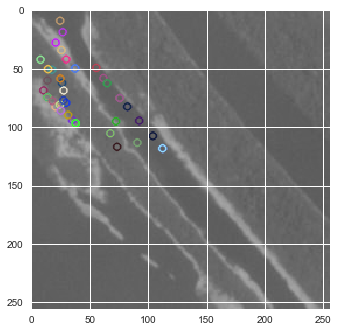

In [31]:
# 10, 16, 20
#sift_test('../data/train-jpg/', 'train_20.jpg')

[<KeyPoint 0x1876d2e10>, <KeyPoint 0x1876d2e40>, <KeyPoint 0x1876d2ea0>, <KeyPoint 0x1876d2de0>, <KeyPoint 0x1876d2db0>, <KeyPoint 0x1876d2d80>, <KeyPoint 0x1876d2d50>, <KeyPoint 0x1876d2cf0>, <KeyPoint 0x1876d2cc0>, <KeyPoint 0x1876d2c90>, <KeyPoint 0x1876d2c60>, <KeyPoint 0x1876d2c30>, <KeyPoint 0x1876d2c00>, <KeyPoint 0x1876d2bd0>, <KeyPoint 0x1876d2ba0>, <KeyPoint 0x1876d2b70>, <KeyPoint 0x1876d2b40>, <KeyPoint 0x1876d2b10>, <KeyPoint 0x1876d2ae0>, <KeyPoint 0x1876d2ab0>, <KeyPoint 0x1876d2a80>, <KeyPoint 0x1876d2a50>, <KeyPoint 0x1876d2a20>, <KeyPoint 0x1876d29f0>, <KeyPoint 0x1876d29c0>, <KeyPoint 0x1876d2990>, <KeyPoint 0x1876d2960>, <KeyPoint 0x1876d2930>, <KeyPoint 0x1876d2900>, <KeyPoint 0x1876d28d0>, <KeyPoint 0x1876d28a0>, <KeyPoint 0x1876d2870>, <KeyPoint 0x1876d2840>, <KeyPoint 0x1876d2810>, <KeyPoint 0x1876d27e0>, <KeyPoint 0x1876d27b0>, <KeyPoint 0x1876d2780>, <KeyPoint 0x1876d2750>, <KeyPoint 0x1876d2720>, <KeyPoint 0x1876d26f0>] [[  2.56818195e-04   4.03929880e-04   2

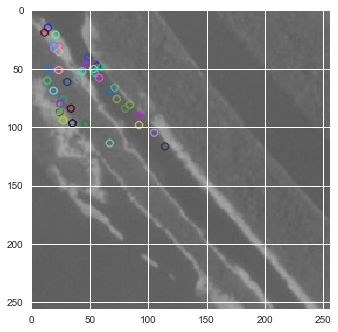

In [32]:
#surf_test('../data/train-jpg/', 'train_20.jpg')

In [33]:
def sift_files(directory, count_break):
    count = 0
    sift_kp = []
    sift_desc = []
    sift_images = []
    sift_failed = []
    for filename in os.listdir(directory):
        if count == count_break and count_break != 0:
            break
        if filename.endswith(".jpg"):
            kp, desc = run_sift(directory, filename)
            if desc is not None:
                sift_kp.append(kp)
                sift_desc.append(desc)
                sift_images.append(filename)
                count += 1
            else:
                sift_failed.append(filename)
    print len(sift_kp), len(sift_desc), len(sift_images)
    return sift_kp, sift_desc, sift_images, sift_failed

In [34]:
def surf_files(directory, count_break):
    count = 0
    surf_kp = []
    surf_desc = []
    surf_images = []
    surf_failed = []
    for filename in os.listdir(directory):
        if count == count_break and count_break != 0:
            break
        if filename.endswith(".jpg"):
            kp, desc = run_surf(directory, filename)
            if desc is not None:
                surf_kp.append(kp)
                surf_desc.append(desc)
                surf_images.append(filename)
                count += 1
            else:
                surf_failed.append(filename)
    print len(surf_kp), len(surf_desc), len(surf_images)
    return surf_kp, surf_desc, surf_images, surf_failed

In [35]:
sift_kp, sift_desc, sift_images, sift_failed = sift_files('../data/train-jpg/', 1000)

1000 1000 1000


In [36]:
surf_kp, surf_desc, surf_images, surf_failed = surf_files('../data/train-jpg/', 1000)

1000 1000 1000


In [13]:
n_samples = len(sift_images)
df['split_tags'] = df['tags'].map(lambda row: row.split(" "))
lb = MultiLabelBinarizer()
y = lb.fit_transform(df['split_tags'])
y = y[:n_samples]
print y.shape

(1000, 17)


In [14]:
features = []
directory = '../data/train-jpg/'
for i in range(0, len(sift_images)): # For each image that gave descriptors
    filename = sift_images[i]
    raw_img = cv2.imread(directory + filename)
    raw_img = cv2.resize(raw_img, (0, 0), fx=0.5, fy=0.5)
    kp, desc = run_sift(directory, filename) 
    combined_feat = np.append(desc.reshape(1, -1), raw_img.reshape(1, -1))
    features.append(combined_feat.reshape(1, -1)[0])
X = np.squeeze(np.array(features))
min = len(X[0])
for i in range(0, len(sift_images)):
    if min > len(X[i]):
        min = len(X[i])
X_final = []
for i in range(0, len(sift_images)):
    X[i] = X[i][:min]
    X_final.append(X[i][:min])
print np.array(X_final).shape
X = np.array(X_final)
print X.shape

(1000, 49280)
(1000, 49280)


In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

((670, 49280), (330, 49280), (670, 17), (330, 17))


In [37]:
# F2 requires true positives (tp), false positives (fp), 
# and false negatives (fn)
def F2_score(tp, fp, fn):
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    beta = 2
    F2_score = (1 + beta**2)*precision*recall/(beta**2*precision+recall)
    return F2_score

def calc_F2_score(X_test, y_test, model):
    score = fbeta_score(y_test, model.predict(X_test), beta=2, average=None)
    return score

In [51]:
clf = OneVsRestClassifier(LinearSVC(penalty='l2'))
clf.fit(X_train, y_train)
score = calc_F2_score(X_test, y_test, clf)

avg_sample_score = fbeta_score(y_test, clf.predict(X_test), beta=2, average='samples')

print('Average F2 test score {}'.format(avg_sample_score))
print('SVC_F2 test scores per tag:')
[(lb.classes_[l], score[l]) for l in score.argsort()[::-1]]

Average F2 test score 0.566678755002
SVC_F2 test scores per tag:


[('primary', 0.95128373930217247),
 ('clear', 0.73853989813242782),
 ('blooming', 0.17857142857142855),
 ('partly_cloudy', 0.17543859649122806),
 ('agriculture', 0.17073170731707316),
 ('water', 0.16611295681063126),
 ('road', 0.10309278350515465),
 ('haze', 0.049019607843137254),
 ('cloudy', 0.046296296296296287),
 ('habitation', 0.033783783783783779),
 ('slash_burn', 0.0),
 ('conventional_mine', 0.0),
 ('blow_down', 0.0),
 ('selective_logging', 0.0),
 ('bare_ground', 0.0),
 ('artisinal_mine', 0.0),
 ('cultivation', 0.0)]

In [55]:
n_samples = len(surf_images)
#n_samples = 200 # avg. F2 = 0.598175283606
df['split_tags'] = df['tags'].map(lambda row: row.split(" "))
lb = MultiLabelBinarizer()
y = lb.fit_transform(df['split_tags'])
y = y[:n_samples]
print y.shape

features = []
directory = '../data/train-jpg/'
for i in range(0, n_samples): # For each image that gave descriptors
    filename = surf_images[i]
    raw_img = cv2.imread(directory + filename)
    raw_img = cv2.resize(raw_img, (0, 0), fx=0.5, fy=0.5)
    kp, desc = run_surf(directory, filename) 
    combined_feat = np.append(desc.reshape(1, -1), raw_img.reshape(1, -1))
    features.append(combined_feat.reshape(1, -1)[0])
X = np.squeeze(np.array(features))
min = len(X[0])
for i in range(0, n_samples):
    if min > len(X[i]):
        min = len(X[i])
X_final = []
for i in range(0, n_samples):
    X[i] = X[i][:min]
    X_final.append(X[i][:min])
print np.array(X_final).shape
X = np.array(X_final)
print X.shape

(1000, 17)
(1000, 49216)
(1000, 49216)


In [56]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

((670, 49216), (330, 49216), (670, 17), (330, 17))


In [58]:
clf = OneVsRestClassifier(LinearSVC(penalty='l2'))
clf.fit(X_train, y_train)
score = calc_F2_score(X_test, y_test, clf)

avg_sample_score = fbeta_score(y_test, clf.predict(X_test), beta=2, average='samples')

print('Average F2 test score {}'.format(avg_sample_score))
print('SVC_F2 test scores per tag:')
[(lb.classes_[l], score[l]) for l in score.argsort()[::-1]]

Average F2 test score 0.578125141198
SVC_F2 test scores per tag:


[('primary', 0.9401159047005796),
 ('clear', 0.74278438030560268),
 ('partly_cloudy', 0.25252525252525249),
 ('agriculture', 0.19916142557651989),
 ('water', 0.1461038961038961),
 ('road', 0.10769230769230768),
 ('haze', 0.10526315789473685),
 ('cultivation', 0.071428571428571438),
 ('cloudy', 0.069444444444444448),
 ('habitation', 0.033112582781456949),
 ('slash_burn', 0.0),
 ('conventional_mine', 0.0),
 ('selective_logging', 0.0),
 ('blow_down', 0.0),
 ('blooming', 0.0),
 ('bare_ground', 0.0),
 ('artisinal_mine', 0.0)]